# End project - C
## Branes Hut algorithm
### Elyasaf Cohen
### 204633705


In [2]:
# initiate 8 workers
using Distributed
if nprocs() < 8
    addprocs(8-nprocs());
end

In [ ]:
@everywhere module BranesHut
#%%
#=
BranesHut:
- Julia version: 1.5.0
- Author: elyco
- Date: 2020-07-19
=#


##################### import #####################
using Distributed
using LinearAlgebra: norm
using Distributions: mean
using Random: seed!
using KernelDensity: kde, pdf
using LsqFit: curve_fit

using Plots
using LaTeXStrings
using Dates
using JSON: JSON, parse
using Formatting: format

include("StructModule.jl")  # import MassSystem and Node classes
using ..StructModule
include("RK.jl")            # import Runga-Kuta solver
include("helper.jl")        # some other helper function like save, plot position, and load.

@everywhere begin
    using LinearAlgebra: norm
    using SharedArrays
    const THETA = 1
    const GRAVITATIONAL_CONSTANT = 4.30091e-3
    const SOFT_PARAM = 1e3  # Parsec
end


##################### constants #####################
const N_INITIAL               = 50    # The total number of star in the simulation
const M_TOT                   = 1e11    # [Sun masses]  The total mass of all the stars
const R_INITIAL               = 50e3    # [Parsec]  The Radius that all the masses start inside
const SOFT_PARAM              = 1e3     # [Parsec]
const MAX_BOX_SIZE            = 666e3   # [Parsec]
# const T_FINAL                 = 20e9  # [years], = 20453 in units time of the exercise
const T_FINAL                 = 20453   # in units time of the exercise
const THETA                   = 1       # parameter that control how deep we need the gey inside the recursion
const GRAVITATIONAL_CONSTANT  = 4.30091e-3  # in the units of the exercise


##################### Trees construct #####################
"""
    build_tree!(system::MassSystem)

Build the tree that contain all the information of the system in OctTree Structure
Return the root of the tree which is attribute of MassSystem
"""
function build_tree!(system::MassSystem)
    borders = get_current_box_size(system)  # x_lim, y_lim, z_lim

    # define a new node with all the masses
    root = Node(borders)
    root.masses_indices = collect(1:system.N)
    root.center_of_mass = mean(system.positions, dims=1)[1,:]
    root.mass_count = system.N

    build_tree_helper!(system, root)
    return root
end

function build_tree_helper!(system::MassSystem, node::Node)
    # divide the tree into 8 parts
    xlim = node.borders[:,1]
    ylim = node.borders[:,2]
    zlim = node.borders[:,3]
    middle_limits = [mean(lim,dims=1) for lim in (xlim,ylim,zlim)]

    borders8 = [[sort!([xlim[i], middle_limits[1][1]]),
                 sort!([ylim[j], middle_limits[2][1]]),
                 sort!([zlim[k], middle_limits[3][1]])]
                for i in 1:2 for j in 1:2 for k in 1:2]

    borders8 = [hcat(b[1],b[2],b[3]) for b in borders8]

    # for each part check its properties and if neede recursive build its children
    leafs = []
    for border in borders8
        leaf = Node(border)
        leaf.parent = node
        fill_attributes!(system,leaf)
        if leaf.mass_count > 0
            push!(leafs, leaf)
            if leaf.mass_count > 1
                build_tree_helper!(system,leaf)
            end
        end
    end
    node.leafs = leafs
end
""""
    fill_attributes!(system, node)

Save to node all the relevant infromation about that node
"""
function fill_attributes!(system, node)
    masses_indices = node.parent.masses_indices[:]
    for i in masses_indices
        point = system.positions[i,:]
        if point_in_box(point, node.borders)
            push!(node.masses_indices,i)
            remove!(node.parent.masses_indices,i)
        end
    end
    if length(node.masses_indices) > 0
        node.center_of_mass = mean(system.positions[node.masses_indices, :], dims=1)[:]
        node.mass_count = length(node.masses_indices)
    end
end


@everywhere function point_in_box(point, borders)
    return borders[1,1] <= point[1] < borders[2,1] &&
           borders[1,2] <= point[2] < borders[2,2] &&
           borders[1,3] <= point[3] < borders[2,3]
end


function remove!(a, item)
    deleteat!(a, findall(x->x==item, a))
end


function get_current_box_size(system::MassSystem)
    x_lim = [minimum(system.positions[:, 1])-1, maximum(system.positions[:, 1])+1]
    y_lim = [minimum(system.positions[:, 2])-1, maximum(system.positions[:, 2])+1]
    z_lim = [minimum(system.positions[:, 3])-1, maximum(system.positions[:, 3])+1]
    return hcat(x_lim, y_lim, z_lim)
end


##################### force/energy calculation #####################

"""
    calculate_force!(system)

Initiate the calculation of the force for each point mass we are saving the force that act on it.
there are two options for the calculation, depend on I want to parralelize it or not.
"""
function calculate_force!(system)
    tmp = convert(SharedArray{Float64,2},zeros(system.N, 3))
    @sync begin
        # pmap(i-> (
        #     point = system.positions[i,:];
        #     tmp[i,:] = calculate_force_helper!(system, system.root, point)
        #     ), 1:system.N)
        @distributed for i in 1:system.N
            point = system.positions[i,:]
            tmp[i,:] .= calculate_force_helper!(system, system.root, point)
        end
    end
    system.forces = tmp
end

"""
    calculate_force_helper!(system, node, point)
Recursive function return the force acting on `point` from all the masses in `node`
"""

@everywhere function calculate_force_helper!(system, node, point)
    force = [0., 0., 0.]
    mass_count = node.mass_count

    if mass_count == 0
        # exit condition from the recursion
        return force
    end

    # define the vector between two point
    distance_vec = node.center_of_mass - point  # attractive force
    distance = norm(distance_vec)

    if mass_count == 1
        # if just 1 mass so the force is simply the force between them
        if distance == 0
            # unless we are calculating for the same point
            return force  # [0., 0., 0.]
        end
        # compute and return the force
        force_amplitude = GRAVITATIONAL_CONSTANT * system.each_mass ^ 2 / (distance + SOFT_PARAM) ^ 2
        force_direction = distance_vec / distance
        return force_amplitude * force_direction
    else
        # mass_count >= 2
        if distance < node.diagonal * THETA || point_in_box(point, node.borders)
            # if too close we are need to get inside the recursion

            for leaf in node.leafs
                force += calculate_force_helper!(system, leaf, point)
            end
            return force
        else
            # we don't need to go further just multiply the force by the number of masses inside this node
            force_amplitude = node.mass_count * GRAVITATIONAL_CONSTANT * system.each_mass ^ 2 / (distance + SOFT_PARAM) ^ 2
            force_direction = distance_vec / distance
            return force_amplitude * force_direction
        end
    end
end

"""
Check if some of the mass escape from the box of calculation and if so erase them from the simulation
"""
function remove_exceeds_masses(system)
    ind_to_del = maximum((system.positions .< -MAX_BOX_SIZE) .| (system.positions .> MAX_BOX_SIZE), dims=2)[:]
    ind_to_del = (1:system.N)[ind_to_del]
    if length(ind_to_del) > 0
        system.N = system.N - length(ind_to_del)
        system.positions  = system.positions[setdiff(1:end, ind_to_del),:]
        system.velocities = system.velocities[setdiff(1:end, ind_to_del),:]
        return nothing
    else
        return nothing
    end
end

R2(x::Float64,y::Float64,z::Float64) = x^2+y^2+z^2
R2(r::Array{Float64,1}) = r[1]^2+r[2]^2+r[3]^2
R2(r::Array{Float64,2}) = @. r[:,1]^2+r[:,2]^2+r[:,3]^2
function calculate_energy(mass_system::MassSystem)
    potential_energy = calculate_potential_energy(mass_system)/2    # no double counting
    v_squre = R2(mass_system.velocities)
    kinectic_energy = 0.5 * mass_system.each_mass * sum(v_squre)
    [kinectic_energy, potential_energy]
end

"""
    ode_to_solve_my_RK(t::Float64,y::Array{Float64,1},system::MassSystem)
Function that translate the RK way that it calcuate thing and the way I implement the problem here.
"""
function ode_to_solve_my_RK(t::Float64,y::Array{Float64,1},system::MassSystem)
    dof = system.N * 3
    set_values_from_flat!(y,system)
    system.root = build_tree!(system)
    calculate_force!(system)

    drdt = y[dof+1:end]
    dvdt = system.forces[:] ./ system.each_mass
    dy = vcat(drdt, dvdt)
end


function start_cal(mass_system::MassSystem, sim_data)
    count_dead = 0
    save_positions = []
    energy = []
    energy_of_lost_massess = []
    kinetic_energy_of_lost_massess = []
    for i in 1:sim_data.n
        # println(i)  # follow the progress of the simulation
        y_0 = zeros(mass_system.N*6, 1)
        y_0[:] = get_current_values(mass_system)
        if mass_system.N < N_INITIAL - count_dead
            count_dead = N_INITIAL - mass_system.N
            println(count_dead, " particles are deads")
        end

        ode_solver = make_solver(ode_to_solve_my_RK, sim_data.t_span, "RK4", sim_data.abstol, mass_system)
        sol = ode_solver(y_0)[2][:,end]  # take the last state from the RK
        set_values_from_flat!(sol, mass_system)

        # calcuate the energy difference before and after we remove the exceeded masses
        energy_before = calculate_energy(mass_system)
                        # TODO: consider the check the after energy just if there are masses that removed
                        # TODO: and the energy calculaion can pararlized too
        remove_exceeds_masses(mass_system)
        energy_after = calculate_energy(mass_system)
        energy_lost = energy_after .- energy_before

        # save the energy
        push!(energy, energy_before)
        push!(energy_of_lost_massess, energy_lost )

        if i % 2 == 0
            # save it at not every step
            push!(save_positions,mass_system.positions)
        end
        if mass_system.N == 0
            println("Simulation is over, no more particles")
            return save_positions, vcat(energy'...) , vcat(cumsum(energy_of_lost_massess)'...)
        end
    end

    save_positions, vcat(energy'...) , vcat(cumsum(energy_of_lost_massess)'...)
end

function run(;velocity = 80., save_data=true)
    seed!(421364) # seed the random number generator for reproducibility

    # define parameters of calculation
    tf = 80.
    t_span = (0., tf)
    n = ceil(Int, T_FINAL/tf)
    abstol = 100.
    sim_data = SimData(t_span, n, abstol)  # save the simulation data in a compact object

    # initialize the system
    mass_system = MassSystem(N_INITIAL,velocity)
    @show N_INITIAL velocity abstol
    mass_system.velocities .-= mean(mass_system.velocities, dims=1) # shift to center of mass frame
    mass_system.root = build_tree!(mass_system)

    # start simulation
    t = @elapsed all_positions, energy, lost_masses_energy = start_cal(mass_system, sim_data)
    n = size(energy)[1]
    #%%
    # return mass_system, sim_data, all_positions, energy, lost_masses_energy
    if save_data || (println("No saving to file"); false)
        println("saving data to folder...");
        # make a folder for saving the results
        gr() # use gr() backend (faster and simpler then plotly)
        folder = create_folder()
        new_folder_rename = folder[1:end-1] * format("_eps_{}_N_mass_{}_repeat_ode_{}_v_{}_time_{:.2f}_m_THETA_{}_jullia/",abstol,N_INITIAL,n,velocity,t/60,THETA)
        mv(folder, new_folder_rename)
        folder = new_folder_rename
        sim_data.folder = folder

        # save results to files
        save_figures(1, all_positions, folder)
        save(folder, mass_system, [energy, lost_masses_energy], ["energy", "lost_masses_energy"])
        # show_gif(all_positions, (40,70))
    end
    return mass_system, sim_data, all_positions, energy, lost_masses_energy
end # run

function run_energy_graphs(sim_data, all_positions, energy, lost_masses_energy; save_data=false)
    # plot the graphs
    tf = sim_data.t_span[2]
    folder = sim_data.folder

    p1 = plot(title="Total Energy")
    p2 = plot(title="Kinetic Energy")
    p3 = plot(title="Potential Energy")
    p4 = plot(title="Rel error of Energy Conservation")
    p5 = plot(title="Virial Thm. relation")
    p6 = plot(title="energy")

    time_series = (0:sim_data.n-1) .* tf
    total_energy1 = sum(energy, dims=2)
    total_energy2 = sum(energy.-lost_masses_energy, dims=2)
    plot!(p1,time_series, total_energy1 , label=L"Energy\ Conservation")
    plot!(p1,time_series, total_energy2, label=L"Energy\ Conservation\ with\ lost")

    plot!(p2,time_series, energy[:,1], label="Kinetic")
    plot!(p2,time_series, (energy.-lost_masses_energy)[:,1], label="Kinetic with lost")

    plot!(p3,time_series, energy[:,2], label="Potential")
    plot!(p3,time_series, (energy.-lost_masses_energy)[:,2], label="Potential with lost")

    plot!(p4, time_series, -1 .+ total_energy1 ./ total_energy1[1], label=L"Energy\ Conservation")
    plot!(p4, time_series, -1 .+ total_energy2 ./ total_energy2[1], label=L"Energy\ Conservation\ with\ lost")


    save_data && savefig(folder*"energy.png")
    plot!(p5,time_series, -2 .* energy[:,1] ./ energy[:,2],label=L"\dfrac{2E_k}{E_p}")
    plot!(p5,time_series, -2 .* (energy[:,1] .- lost_masses_energy[:,1]) ./ (energy[:,2] .- lost_masses_energy[:,2]),label=L"\dfrac{2E_k}{E_p}+lost\ masses")
    save_data && savefig(folder*"ratio.png")
    # xlabel!("t"*" [astrnumical units]")

    # length(all_p[1])==6 && plot!(p6,(0:length(all_positions)-1) .* tf,R2.([p[1,:]-p[2,:] for p in all_positions]))
    plot(p1,p4,p5,p2,p3,legend=false,size=(600,1600), layout=(5,1))
end # run_energy_graphs

#%%
function find_density(system::MassSystem; save_data=false, folder="")
    p = system.positions
    COM = system.root.center_of_mass
    radii = @. sqrt((p[:,1] - COM[1])^2 +(p[:,2] - COM[2])^2 +(p[:,2] - COM[3])^2)
    find_density(radii, save_data=false, folder=folder)
end

function find_density(radii::Array{Float64,1}; save_data=false, folder="")
    gr()
    xdata = range(minimum(radii), maximum(radii),length=5*10^2)
    # xdata = range(minimum(radii), 10. ^5.5,length=5*10^2)
    p = kde(radii)
    ydata = pdf(p,xdata)
    inds = [i for i in 1:length(ydata) if ydata[i]>0 && xdata[i]<10^5.5]
    xdata = xdata[inds]
    ydata = ydata[inds]

    # curve_fit
    # @. model(x, p) =  p[1]*x^2/(1 + (x/p[2])^p[3] )^(p[4])
    # p0 = [1e-5,10^4.7,5.13,2.2]
    # p0 = [1e-14, 4e4, 2.1, 3.05]
    # p0=[6.52e-10, 7.1e+04, 1., 7.]
    # p0 = [1.e-13, 159040., 1., 14.] #[1.102829573732584e-13, 159040.00000000675, 1.0015000953676354, 13.999914095981763]
    # p0 = [1.e-13, 159040., 2., 2.5] #[9.670895322014411e-14, 75887.91935011698, 1.4498570607553147, 6.835788293565527]
    # p0 = [1.e-13, 159040., 2., 2.5]
    # p0 = [1., 100000., 2., 14.]
    #
    # lb = [0 ,0.,0.,0.]  # lower bound
    # # ub = [1 ,1e6,3.,3.]  # upper bound
    # ub = [Inf ,Inf,Inf,Inf]  # upper bound
    # fit = curve_fit(model, xdata, ydata, p0 ,lower=lb,upper=ub)

    α=2.
    β=2.5
    # α = 1.170978892990167
    # β = 15.496487531262101
    @. model(x, p) = p[1]*x^2/(1 + (x/p[2])^α )^β

    @show α, β
    p0 = [1., 100000.]
    lb = [0 ,0.]  # lower bound
    # ub = [1 ,1e6]  # upper bound
    ub = [Inf ,Inf]  # upper bound
    fit = curve_fit(model, xdata, ydata, p0 ,lower=lb,upper=ub)

    println(fit.param)
    println(sum(fit.resid.^2))

    plo = scatter(xdata, ydata, xaxis=:log,yaxis=:log,
                marker=(:circle),
                # line=:none,
                label="simulation",
                legend=:bottomleft)
    # plo = plot(xdata,ydata, marker="o", label="simulation")
    plot!(xdata, model(xdata,fit.param), label="fit")
    save_data && savefig(folder*"king"*string(fit.param...)*".png")
    plo
    # density
    # fit
    # @show trapz(xdata,ydata)
end
using Trapz
using Main: calculate_force_helper!,point_in_box

end  # module BranesHut

In [37]:
using Plots
function run_all()
    for v in [65., 80., 95.]
        mass_system, sim_data, all_p, erg, lost_erg  = BranesHut.run(velocity=v, save_data=true)
        BranesHut.run_energy_graphs(sim_data, all_p, erg, lost_erg, save_data=true)
        BranesHut.find_density(mass_system, save_data=true, folder=sim_data.folder)
    end
end

run_all (generic function with 1 method)

### v = 65; $\theta$ = 1
![SegmentLocal](65.gif "segment")
### v = 80; $\theta$ = 1
![SegmentLocal](80.gif "segment")
### v = 95; $\theta$ = 1
![SegmentLocal](95.gif "segment")
### v = 80; $\theta$ = 10
![SegmentLocal](theta_10.gif "segment")

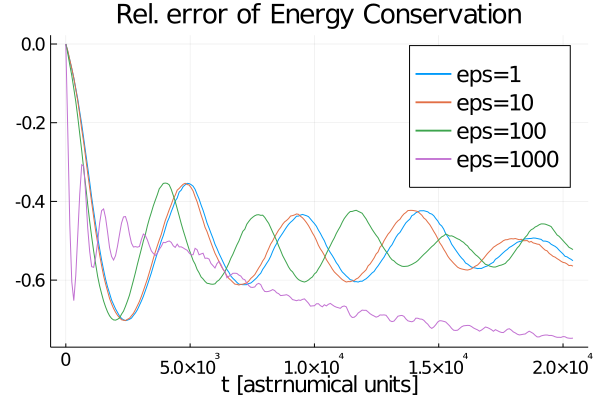

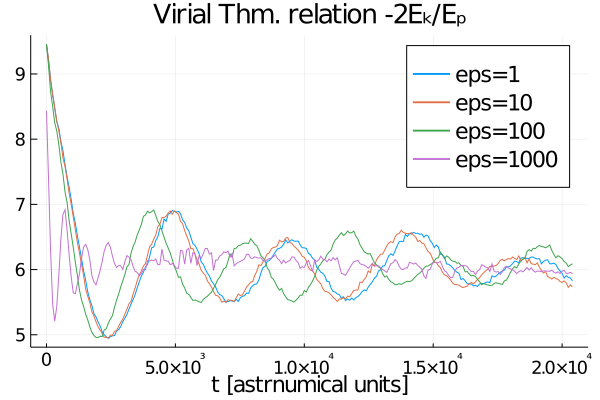

In [34]:
function arange_plots_epsilon()
    folder = "C:/Users/owner/Documents/Branes hut/results/epsilon check different epsilon/"
    default(titlefontsize = 18,
            legendfontsize = 15,
            guidefontsize = 15,
            tickfontsize = 12)
    energy_plt = plot(title="Rel. error of Energy Conservation")
    virial_plt = plot(title="Virial Thm. relation -2Eₖ/Eₚ")
    for fold in readdir(folder)
        if !isdir(folder*fold)
            continue
        end
        # println(fold)
        ind = findfirst("eps_",fold)[end] + 1
        ind_ = findnext("_", fold, ind)[1]
        abstol = parse(Float64,fold[ind:ind_-1])
        mass_system, sim_data, energy, lost_masses_energy = BranesHut.load(folder*fold*"/","energy","lost_masses_energy");

        tf = sim_data.t_span[2]

        time_series = (0:sim_data.n-1) .* tf
        total_energy1 = sum(energy, dims=2)
        total_energy2 = sum(energy.-lost_masses_energy, dims=2)
        plot!(energy_plt, time_series, -1 .+ total_energy2 ./ total_energy2[1], label=string("eps=",Int64(abstol)))
        xlabel!("t"*" [astrnumical units]")

        plot!(virial_plt,
                time_series,
                -2 .* (energy[:,1] .- lost_masses_energy[:,1]) ./ (energy[:,2] .- lost_masses_energy[:,2]),
                label=string("eps=",Int(abstol)))

        xlabel!("t"*" [astrnumical units]")
    end
    save_data = true
    save_data && savefig(energy_plt, folder*"energy_new.png")
    save_data && savefig(virial_plt, folder*"ratio_new.png")

    display(energy_plt)
    display(virial_plt)
end # function arange_plots_epsilon
arange_plots_epsilon()

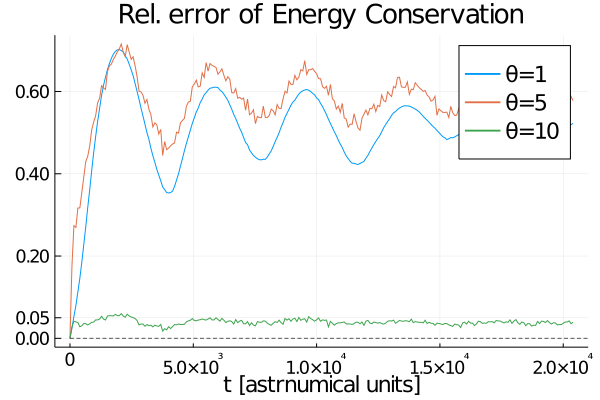

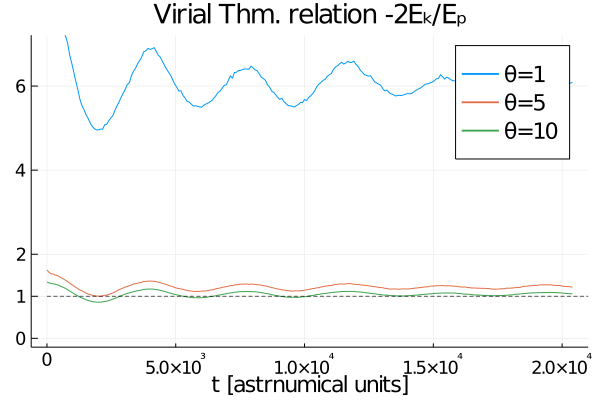

In [31]:
function arange_plots_theta()
    folder = "C:/Users/owner/Documents/Branes hut/results/theta/"
    default(titlefontsize = 18,
            legendfontsize = 15,
            guidefontsize = 15,
            tickfontsize = 12)
    energy_plt = plot(title="Rel. error of Energy Conservation")
    virial_plt = plot(title="Virial Thm. relation -2Eₖ/Eₚ")
    for fold in readdir(folder)
        if !isdir(folder*fold)
            continue
        end
        sub_fold = readdir(folder*fold*"/")[1]
        # println(fold)
        # println(sub_fold)
        ind = findfirst("theta_",fold)[end] + 1
        ind_ = findnext(" ", fold, ind)[1]
        theta = parse(Int64,fold[ind:ind_-1])
        mass_system, sim_data, energy, lost_masses_energy = BranesHut.load(folder*fold*"/"*sub_fold*"/","energy","lost_masses_energy");

        tf = sim_data.t_span[2]

        time_series = (0:sim_data.n-1) .* tf
        total_energy1 = sum(energy, dims=2)
        total_energy2 = sum(energy.-lost_masses_energy, dims=2)
        plot!(energy_plt,
              time_series, abs.(-1 .+ total_energy2 ./ total_energy2[1]),
              label=string("θ=",theta),
              yticks=[0.0,0.05,0.2,0.4,0.6,-0.2,-0.4,-0.6],)
        xlabel!("t"*" [astrnumical units]")

        plot!(virial_plt,
                time_series,
                -2 .* (energy[:,1] .- lost_masses_energy[:,1]) ./ (energy[:,2] .- lost_masses_energy[:,2]),
                label=string("θ=",theta),
                yticks=[0, 1,2,4,6],
                ylim=[0,7])
        xlabel!("t"*" [astrnumical units]")
    end
    save_data = true
    plot!(virial_plt, [0, 2e5], [1,1], line=(:black,0.65,:dash),label="")
    xlims!((-612.0, 21012.0))
    plot!(energy_plt, [0, 2e5], [0,0], line=(:black,0.65,:dash),label="")
    xlims!((-612.0, 21012.0))
    save_data && savefig(energy_plt, folder*"energy_new.png")
    save_data && savefig(virial_plt, folder*"ratio_new.png")

    display(energy_plt)
    display(virial_plt)
end # function arange_plots_theta
arange_plots_theta()

(α, β) = (2.0, 2.5)
[2.3650625158679553e-13, 23800.15639479748]
1.0030059320466057e-10
(α, β) = (2.0, 2.5)
[8.006128340840988e-14, 34276.46098775136]
5.137532746445872e-11

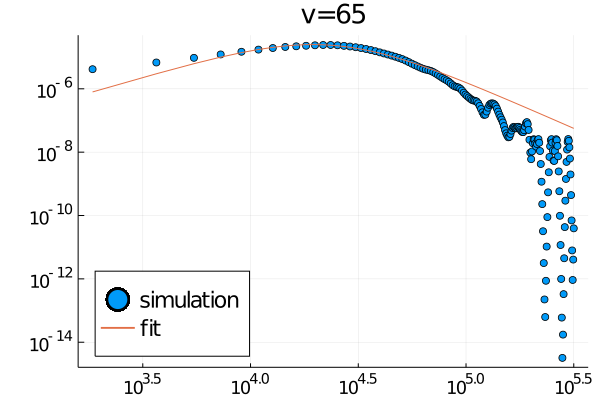

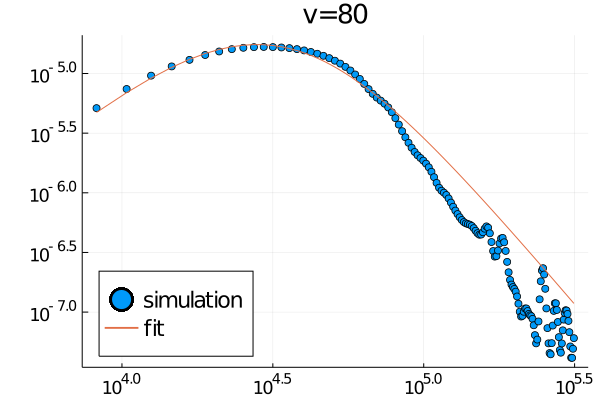

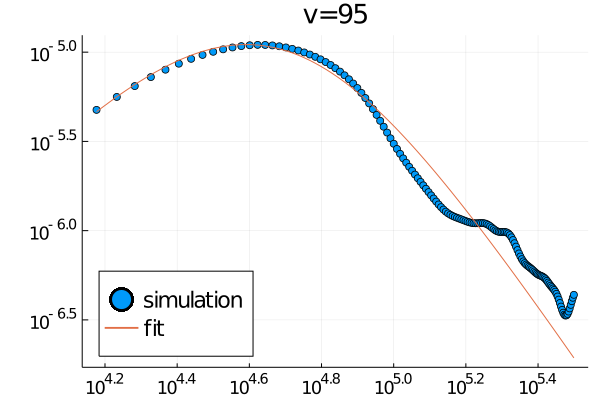

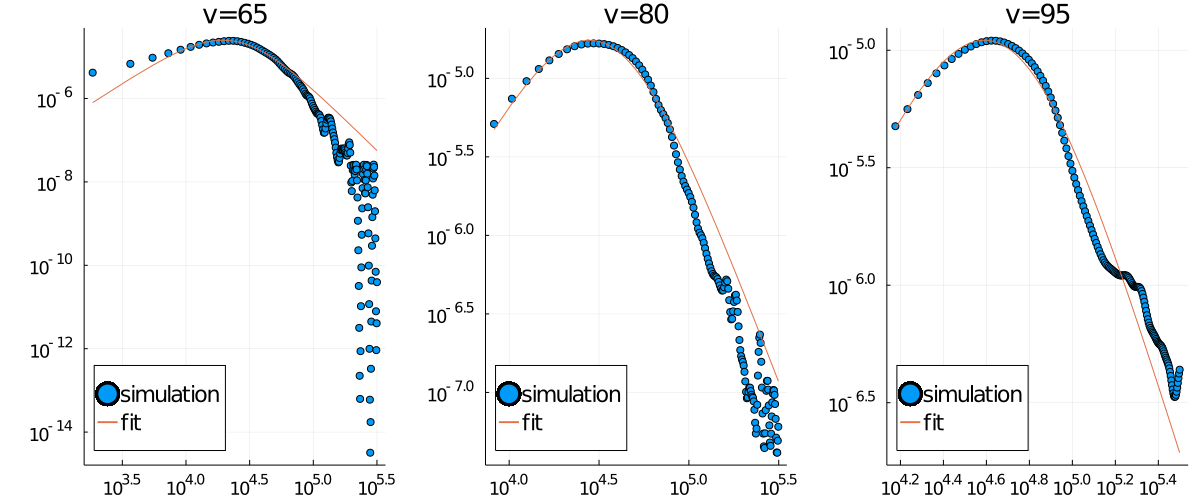


(α, β) = (2.0, 2.5)
[2.6068765681250222e-14, 47715.741399139726]
2.437719566523383e-11


In [33]:
using Plots.PlotMeasures
function arange_plots_king()
    folder = "C:/Users/owner/Documents/Branes hut/results/Theta 10 5000/"
    folder = "C:/Users/owner/Documents/Branes hut/results/5000_masses_parrallel_theta_1/"
    default(titlefontsize = 18,
            legendfontsize = 15,
            guidefontsize = 15,
            tickfontsize = 12)
    king_plts = []
    for fold in readdir(folder)
        if !isdir(folder*fold)
            continue
        end
        # println(fold)
        # println(sub_fold)
        ind = findfirst("_v_",fold)[end] + 1
        ind_ = findnext("_", fold, ind)[1]
        velocity = Int64(parse(Float64,fold[ind:ind_-1]))
        mass_system, sim_data, energy, lost_masses_energy = BranesHut.load(folder*fold*"/","energy","lost_masses_energy");


        king_plt = BranesHut.find_density(mass_system)
        if velocity == 65
            title!("v="*string(velocity))
        else
            title!("v="*string(velocity))
        end
        push!(king_plts, (king_plt, velocity))
    end
    save_data = true
    for (plt,v) = king_plts
        save_data && savefig(plt, folder*"king_v_"*string(v)*".png")
        display(plt)
    end
    plot([tup[1] for tup in king_plts]..., layout=(1,3),size=(1200,500),bottommargin = 10px)
    display(current())
    save_data && savefig(folder*"king_v_all.png")
end # function arange_plots_king
arange_plots_king()

In [ ]:
# fit results
(α, β) = (2, 2.5)
[2.3651460048170533e-13 23799.75151410114;
# 1.0035746984932837e-10
8.007047118514466e-14 34274.549918442004;
# 5.1467324712358616e-11
2.6029150357004136e-14 47750.8176403658]
# 2.5631062896548546e-11

# [2.36515e-13  23799.8;
#  8.00705e-14  34274.5;
#  2.60292e-14  47750.8]

#%%
(α, β) = (1.170978892990167, 15.496487531262101)
[3.419372904885111e-13 124263.58280424828;
# 3.8509425973482815e-11
1.1689651825688522e-13 178328.0219051083;
# 7.292271829391736e-12
3.9168700945470973e-14 244935.1201844184]
# 3.3421744501272296e-11

3.41937e-13  124264.0
1.16897e-13  178328.0
3.91687e-14  244935.0